# Import libraries

In [1]:
# Standard Library
import os
import sys
import subprocess
import random
import math
from math import floor
from collections import Counter

# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Preprocessing and Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Statistical Analysis
import statsmodels.api as sm
import scipy.stats as stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Clustering
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
from sklearn.decomposition import PCA

# Dimensionality Reduction
import umap

# Deep Learning
import tensorflow as tf
from tensorflow.keras import regularizers, Input, Model, layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Module Utilities
import importlib.util

2024-12-12 13:21:16.338510: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 13:21:16.339533: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 13:21:16.344766: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 13:21:16.357762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734006076.375991   19343 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734006076.38

In [2]:
# Get the current working directory and append the parent directory
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, '..'))

# Add the parent directory to sys.path
sys.path.append(parent_directory)

In [3]:
from scripts.create_genotype import simulate_genos
from scripts.parse_vars import parse_variables
from scripts.calculate_true_maf_per_pop import calculate_true_maf_per_pop

# Usefull functions

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.model_selection import train_test_split
import numpy as np

class BottleneckDiversityLossLayer(layers.Layer):
    def __init__(self, scale=1e-4, **kwargs):
        super().__init__(**kwargs)
        self.scale = scale

    def call(self, bottleneck_output):
        # Debugging: Use tf.print to monitor bottleneck outputs during training
        mean = tf.reduce_mean(bottleneck_output, axis=0)  # Mean across features (bottleneck dimensions)
        stddev = tf.math.reduce_std(bottleneck_output, axis=0)  # Standard deviation across features
        #tf.print("Bottleneck mean (across features):", mean)
        #tf.print("Bottleneck stddev (across features):", stddev)
        
        # Compute variance penalty across the bottleneck dimensions (across features)
        variance_penalty = tf.reduce_mean(stddev)  # Mean of stddev across bottleneck features
        
        # Add scaled penalty to the loss
        self.add_loss(-self.scale * variance_penalty)
        
        return bottleneck_output


def abyss(geno_in, geno_out, bottleneck_nr, hidden_layer_nr, epoch, patience):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(geno_in, geno_out, test_size=0.2, random_state=42)
    
    # Regularization parameters
    l2_regularizer = 0.1
    activity_regularizer = regularizers.l1(1e-5)

    # Input Layer
    input_layer = layers.Input(shape=(geno_in.shape[1],))
    
    # Add noise for denoising autoencoder
    noisy_input = layers.GaussianNoise(0.1)(input_layer)
    
    # Encoder
    hidden = layers.Dense(hidden_layer_nr, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer))(noisy_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(0.5)(hidden)
    
    
    bottleneck = layers.Dense(bottleneck_nr, activation='elu',
                               name='bottleneck',
                               kernel_regularizer=regularizers.l2(l2_regularizer),
                               activity_regularizer=activity_regularizer)(hidden)
    bottleneck = BottleneckDiversityLossLayer()(bottleneck)
    bottleneck = layers.LayerNormalization()(bottleneck)  # Normalize bottleneck output
    bottleneck = layers.Activation('elu')(bottleneck)  # Reapply activation after normalization

    
    # Decoder
    hidden = layers.Dense(hidden_layer_nr, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer))(bottleneck)
    output_layer = layers.Add()([layers.Dense(geno_out.shape[1], activation='linear', kernel_regularizer=regularizers.l2(l2_regularizer))(hidden), input_layer])
    
    # Define the autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)

    # Optimizer with Cosine Decay
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.01, decay_steps=10000, alpha=0.1)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the autoencoder
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Train the autoencoder
    history = autoencoder.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    
    # Extract the bottleneck model
    bottleneck_model = Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)
    
    # Monitor Bottleneck Variance
    bottleneck_output = bottleneck_model.predict(X_test)
    #print("Bottleneck variance:", np.var(bottleneck_output, axis=0))
    
    return autoencoder, bottleneck_model, history

# Parse variables

In [5]:
dict = parse_variables('params_geno_simul.txt')
if 'G' not in globals():
    G = int(dict['G'])
if 'L' not in globals():
    L = int(dict['L'])
if 'c' not in globals():
    c = int(dict['c'])
if 'k' not in globals():
    k = int(dict['k'])
if 'M' not in globals():
    M = float(dict['M'])

if 'very_rare_threshold_L' not in globals():
    very_rare_threshold_L = float(dict['very_rare_threshold_L'])
if 'very_rare_threshold_H' not in globals():
    very_rare_threshold_H = float(dict['very_rare_threshold_H'])
if 'rare_threshold_L' not in globals():
    rare_threshold_L = float(dict['rare_threshold_L'])
if 'rare_threshold_H' not in globals():
    rare_threshold_H = float(dict['rare_threshold_H'])
if 'common_threshold_L' not in globals():
    common_threshold_L = float(dict['common_threshold_L'])
if 'common_threshold_H' not in globals():
    common_threshold_H = float(dict['common_threshold_H'])

# Import Genotype

In [6]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/"
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/"
humans = pd.read_pickle(f"{path_pheno}/inbred_humans.pkl")
complete = pd.read_pickle(f"{path_geno}/complete_inbred.pkl")

In [7]:
try:
    true_p2s = pd.read_pickle(f"{path_geno}/true_p2s.pkl")
    true_twopqs = pd.read_pickle(f"{path_geno}/true_2pqs.pkl")
    true_q2s = pd.read_pickle(f"{path_geno}/true_q2s.pkl")
except:
    true_p2s, true_twopqs, true_q2s = calculate_true_maf_per_pop(complete, humans)
    true_p2s.to_pickle(f"{path_geno}/true_p2s.pkl")
    true_twopqs.to_pickle(f"{path_geno}/true_2pqs.pkl")
    true_q2s.to_pickle(f"{path_geno}/true_q2s.pkl")

In [8]:
#complete = complete.map(lambda x: 1 if x in [-1, 0] else 0)

# Get for all the populations the exact allele frequencies per snp

In [9]:
true_p2s['populations'] = humans['populations']
true_twopqs['populations'] = humans['populations']
true_q2s['populations'] = humans['populations']

In [10]:
global_AFs = [float(col.split("_")[1]) for col in complete.columns]
snps_AFs = pd.DataFrame()
snps_AFs['AF Global'] = global_AFs
for pop in true_p2s['populations'].unique():
    temp_p2 = true_p2s[true_p2s['populations'] == pop]
    temp_p2 = temp_p2.drop("populations", axis=1)
    p2_afs = temp_p2.mean(axis = 0)

    temp_2pq = true_twopqs[true_twopqs['populations'] == pop]
    temp_2pq = temp_2pq.drop("populations", axis=1)
    twopq_afs = temp_2pq.mean(axis = 0)

    temp_q2 = true_q2s[true_q2s['populations'] == pop]
    temp_q2 = temp_q2.drop("populations", axis=1)
    q2_afs = temp_q2.mean(axis = 0)
    
    snps_AFs[f"p2_pop_{pop}"] = list(p2_afs)
    snps_AFs[f"2pq_pop_{pop}"] = list(twopq_afs)
    snps_AFs[f"q2_pop_{pop}"] = list(q2_afs)
snps_AFs['index'] = p2_afs.index

# Calculate LD between snps

In [11]:
"""
from scipy.stats import pearsonr
# Extract relevant columns for LD computation
data = complete.to_numpy()

# Function to compute r^2
def calculate_r2(locus1, locus2):
    # Pearson correlation
    r, _ = pearsonr(locus1, locus2)
    return r**2

# Example: Calculate LD for the first two loci
locus1 = data[:, 0]  # First column
locus2 = data[:, 1]  # Second column
r2 = calculate_r2(locus1, locus2)
print(f"r^2 between locus 1 and 2: {r2}")

# Generalize to pairwise LD for all loci
num_loci = data.shape[1]
ld_matrix = np.zeros((num_loci, num_loci))

for i in range(num_loci):
    for j in range(i, num_loci):  # Symmetric matrix, calculate only once
        ld_matrix[i, j] = calculate_r2(data[:, i], data[:, j])
        ld_matrix[j, i] = ld_matrix[i, j]  # Mirror

# Convert to DataFrame for better visualization
ld_df = pd.DataFrame(ld_matrix, columns=complete.columns, index=complete.columns)
"""

'\nfrom scipy.stats import pearsonr\n# Extract relevant columns for LD computation\ndata = complete.to_numpy()\n\n# Function to compute r^2\ndef calculate_r2(locus1, locus2):\n    # Pearson correlation\n    r, _ = pearsonr(locus1, locus2)\n    return r**2\n\n# Example: Calculate LD for the first two loci\nlocus1 = data[:, 0]  # First column\nlocus2 = data[:, 1]  # Second column\nr2 = calculate_r2(locus1, locus2)\nprint(f"r^2 between locus 1 and 2: {r2}")\n\n# Generalize to pairwise LD for all loci\nnum_loci = data.shape[1]\nld_matrix = np.zeros((num_loci, num_loci))\n\nfor i in range(num_loci):\n    for j in range(i, num_loci):  # Symmetric matrix, calculate only once\n        ld_matrix[i, j] = calculate_r2(data[:, i], data[:, j])\n        ld_matrix[j, i] = ld_matrix[i, j]  # Mirror\n\n# Convert to DataFrame for better visualization\nld_df = pd.DataFrame(ld_matrix, columns=complete.columns, index=complete.columns)\n'

# Divide into AF chunks

In [12]:
nr_chunks = 5
segments = []

# Extract numeric values and sort columns
sorted_columns = sorted(complete.columns, key=lambda col: float(col.split('_')[1]))

# Calculate segment sizes
segment_sizes = [math.ceil(len(sorted_columns) / nr_chunks) if i < len(sorted_columns) % nr_chunks else len(sorted_columns) // nr_chunks for i in range(nr_chunks)]

start = 0
for size in segment_sizes:
    segments.append(complete[sorted_columns[start:start+size]])
    start += size

# Vizualize the AFs dispertion

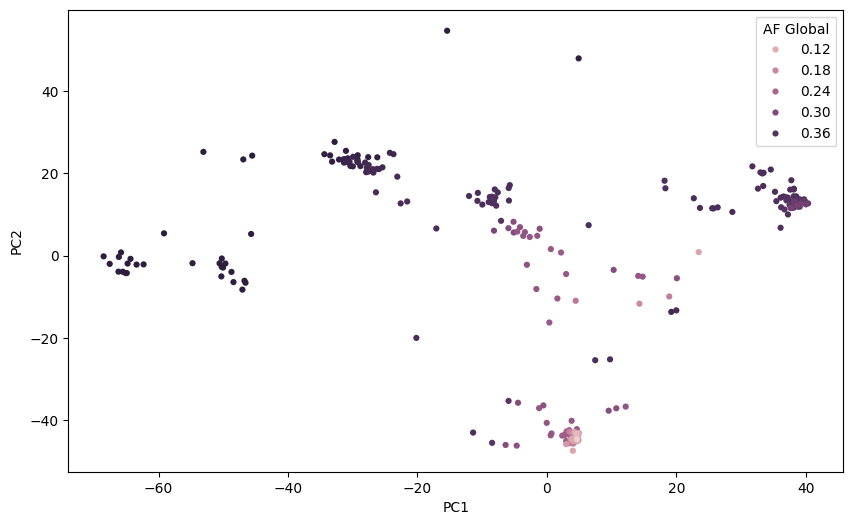

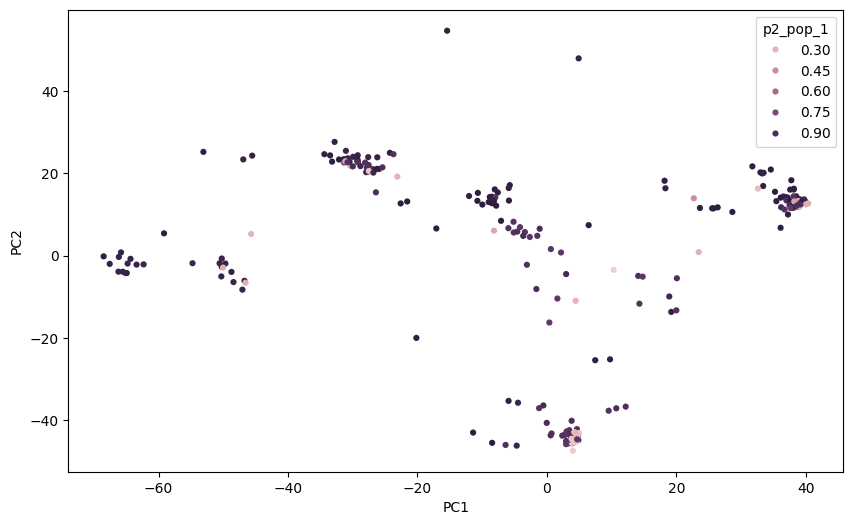

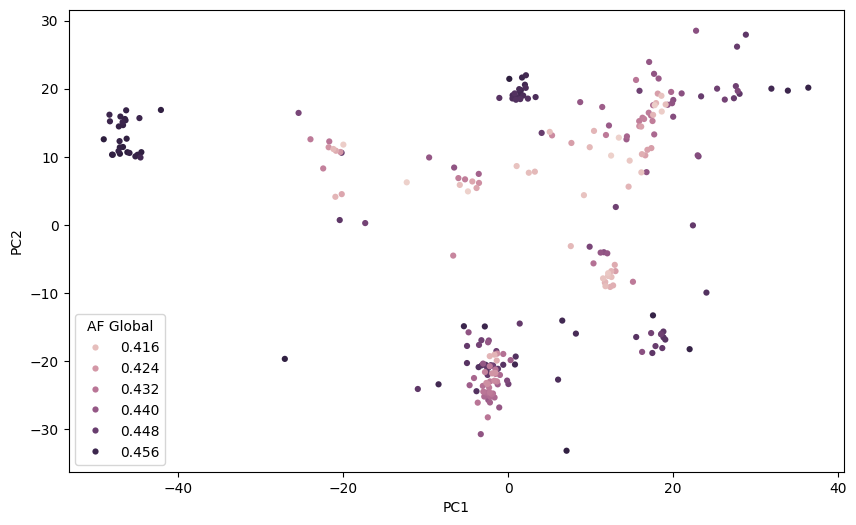

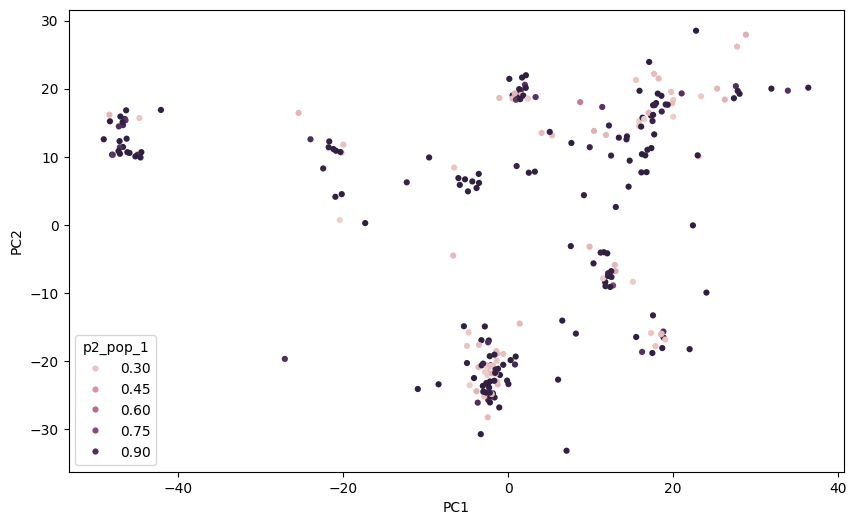

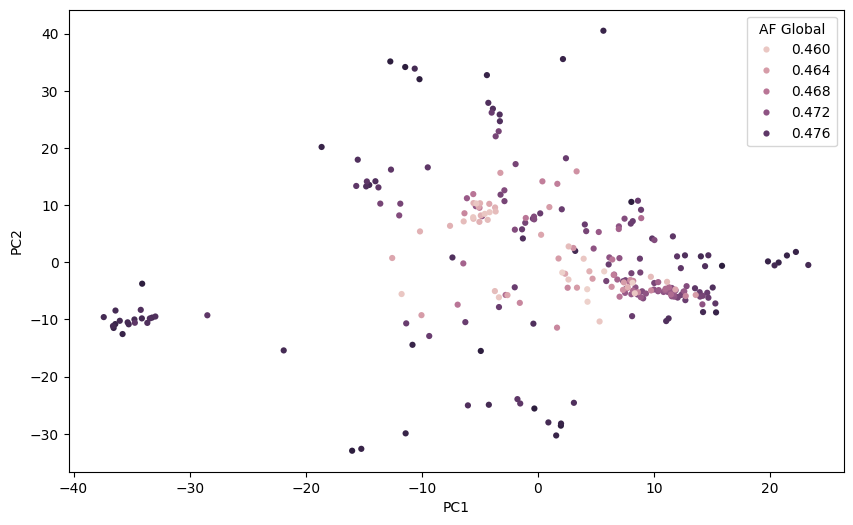

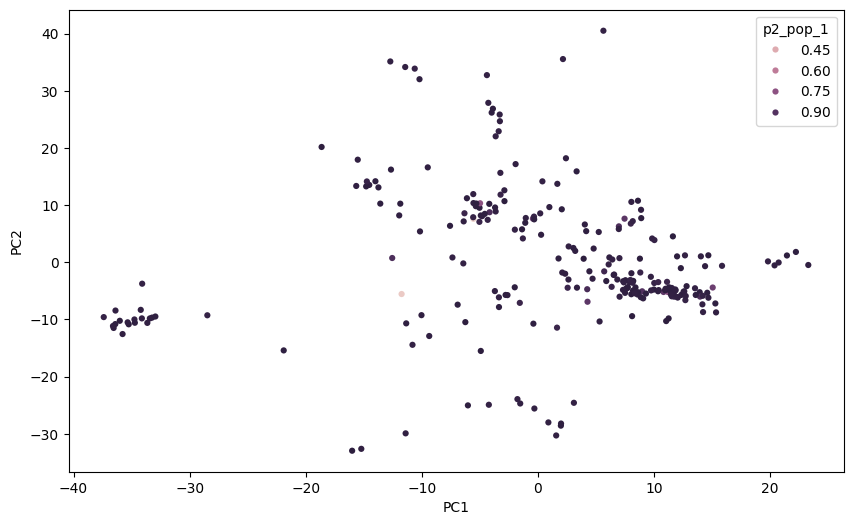

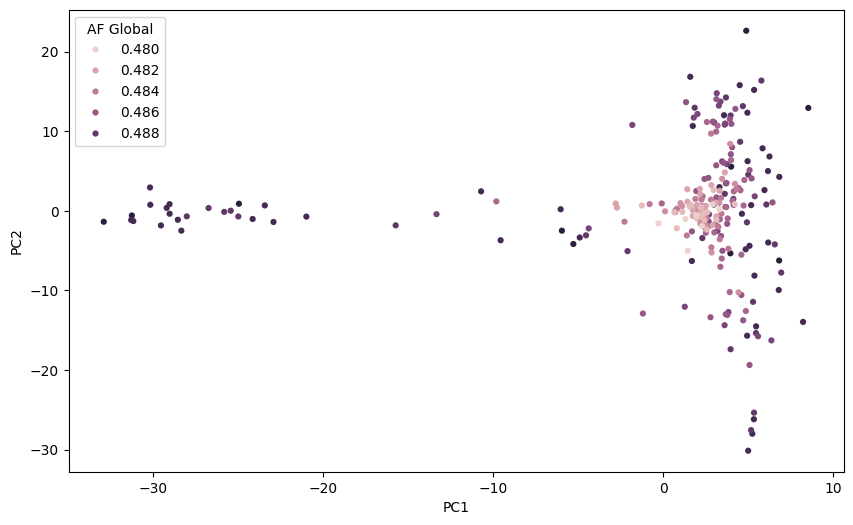

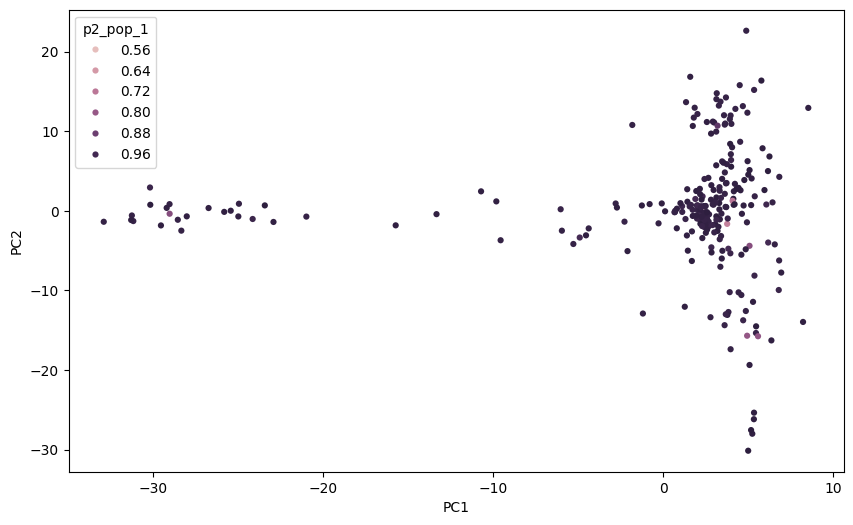

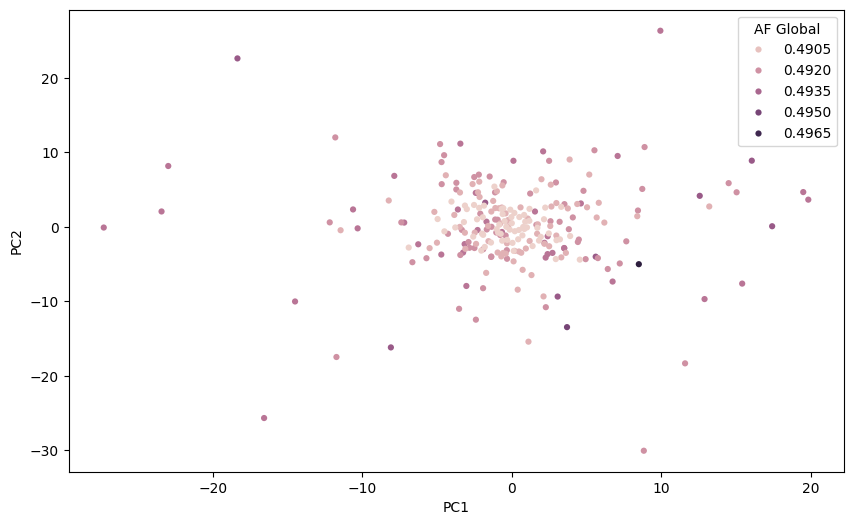

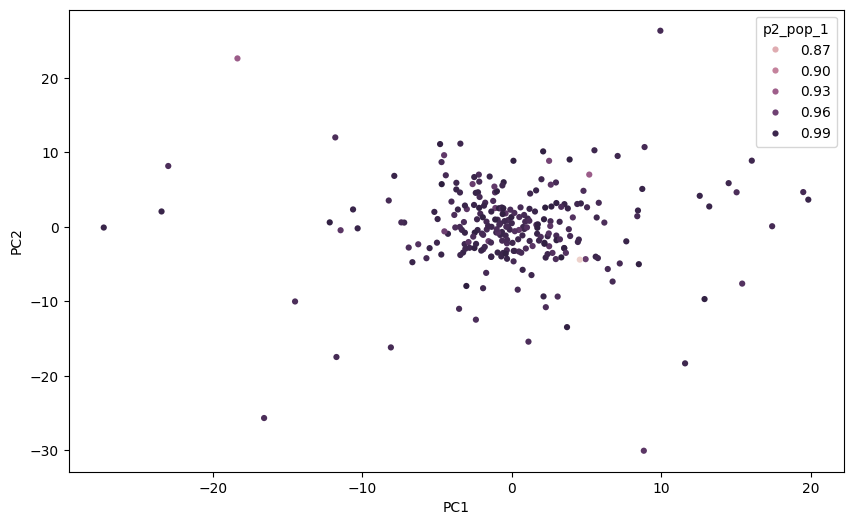

In [13]:
for segment in segments:
    snps = segment.T
    scaler = StandardScaler()
    scaled_snps = scaler.fit_transform(snps)
    n_components = 5
    pca = PCA(n_components=n_components)
    pc_labels_snps = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_snps = pca.fit_transform(scaled_snps)
    PC_snps = pd.DataFrame(data=PC_snps, columns=pc_labels_snps)
    temp = segment.T[[0]]
    temp['index'] = snps.index
    snps_AFs_segment = pd.merge(snps_AFs, temp, on='index', how='inner')
    PC_snps = pd.concat([PC_snps, snps_AFs_segment], axis=1)
    
    plt.figure(figsize=(10, 6))
    
    # First scatter plot
    sns.scatterplot(
        data=PC_snps,
        x="PC1",
        y="PC2",  # Set color for this dataset
        s=20,          # Adjust point size
        linewidth=0, # Adjust edge width
        edgecolor="black",
        hue="AF Global"
        # Set edge color
    )
    
    genotype = 'p2'
    pop = '1'
    
    # Assuming 'humans', 'colors', etc. are already defined
    plt.figure(figsize=(10, 6))
    
    # First scatter plot
    sns.scatterplot(
        data=PC_snps,
        x="PC1",
        y="PC2",  # Set color for this dataset
        s=20,          # Adjust point size
        linewidth=0, # Adjust edge width
        edgecolor="black",
        hue=f"{genotype}_pop_{pop}"
        # Set edge color
    )


# Divide in blocks

In [14]:
segments[0]

,G1250_0.064,G1249_0.1,G1248_0.12,G1247_0.123,G1246_0.124,G1245_0.127,G1244_0.13,G1243_0.131,G1240_0.132,G1241_0.132,...,G1005_0.411,G1006_0.411,G1007_0.411,G1008_0.411,G1009_0.411,G1010_0.411,G1011_0.411,G1012_0.411,G997_0.412,G998_0.412
0,1.0,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,0.0,1.0,-1.0,0.0,-1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,0.0,-1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6246,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6247,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6248,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [15]:
max_trainable_sample_size = 2000
for segment in segments:
    AFs = [float(col.split("_")[1]) for col in segment.columns]
    maf_min = AFs[0]
    maf_max = AFs[-1]

    path_pop = f"{path_geno}/LD_blocks/block_{maf_min}_{maf_max}/"
    os.makedirs(path_pop, exist_ok =True)
    
    snps = segment.T
    sample_size = snps.shape[1]
    feature_size = snps.shape[0]
    
    max_trainable_feature_size = int(sample_size/20)
    if max_trainable_feature_size > feature_size:
        max_trainable_feature_size = feature_size
    n_clusters = int(feature_size/max_trainable_feature_size)
    
    size_min = max_trainable_feature_size - max_trainable_feature_size*0.5
    size_max = max_trainable_feature_size + max_trainable_feature_size*0.5
    if size_max > feature_size:
        size_max = feature_size
        size_min = None
    
    if size_max*n_clusters < feature_size:
        n_clusters +=1
    
    # Apply constrained K-Means clustering
    clf = KMeansConstrained(
        n_clusters=n_clusters,
        size_min=size_min,
        size_max=size_max,
        random_state=0
    )
    
    # Apply KMeans clustering to the UMAP embeddings
    clf.fit_predict(np.array(snps))
    
    snps['ld_block'] = clf.labels_
    
    for block in snps['ld_block'].unique():
        temp_block = snps[snps['ld_block'] == block].drop("ld_block", axis=1).T
        nr_snps_block = temp_block.shape[1]
        temp_block.to_pickle(f"{path_pop}/block_{block}_{nr_snps_block}_snps.pkl")

# Vizualize with non-linearity

In [16]:
"""
b_bottle = 2
h_hidden_layer = 15
epoch = 500
patience = 200
for segment in segments[0:2]:
    scaler = StandardScaler()
    scaled_snps = scaler.fit_transform(segment.T)
    autoencoder, bottleneck_model, history = abyss(scaled_snps, scaled_snps, b_bottle, h_hidden_layer, epoch, patience)
    snps_esti = pd.DataFrame(data=autoencoder(segment.T), columns = segment.T.columns, index = segment.T.index)
    #snps_esti.to_pickle(f"{path_output}/{file_name}_geno_esti.pkl")
    dim_labels = [f"dim{i}" for i in range(1, b_bottle + 1)]
    bottle = pd.DataFrame(data=bottleneck_model(scaled_snps), columns = dim_labels)
    #bottle.to_pickle(f"{path_output}/bottle_{file_name}_geno_esti.pkl")

    temp = segment.T[[0]]
    temp['index'] = segment.T.index
    snps_AFs_segment = pd.merge(snps_AFs, temp, on='index', how='inner')
    dims_snps = pd.concat([bottle, snps_AFs_segment], axis=1)

    
    plt.figure(figsize=(10, 6))
    
    # First scatter plot
    sns.scatterplot(
        data=dims_snps,
        x="dim1",
        y="dim2",  # Set color for this dataset
        s=20,          # Adjust point size
        linewidth=0, # Adjust edge width
        edgecolor="black",
        hue="AF Global"
        # Set edge color
    )
    
    genotype = 'p2'
    pop = '1'
    
    # Assuming 'humans', 'colors', etc. are already defined
    plt.figure(figsize=(10, 6))
    
    # First scatter plot
    sns.scatterplot(
        data=dims_snps,
        x="dim1",
        y="dim2",  # Set color for this dataset
        s=20,          # Adjust point size
        linewidth=0, # Adjust edge width
        edgecolor="black",
        hue=f"{genotype}_pop_{pop}"
        # Set edge color
    )
"""

'\nb_bottle = 2\nh_hidden_layer = 15\nepoch = 500\npatience = 200\nfor segment in segments[0:2]:\n    scaler = StandardScaler()\n    scaled_snps = scaler.fit_transform(segment.T)\n    autoencoder, bottleneck_model, history = abyss(scaled_snps, scaled_snps, b_bottle, h_hidden_layer, epoch, patience)\n    snps_esti = pd.DataFrame(data=autoencoder(segment.T), columns = segment.T.columns, index = segment.T.index)\n    #snps_esti.to_pickle(f"{path_output}/{file_name}_geno_esti.pkl")\n    dim_labels = [f"dim{i}" for i in range(1, b_bottle + 1)]\n    bottle = pd.DataFrame(data=bottleneck_model(scaled_snps), columns = dim_labels)\n    #bottle.to_pickle(f"{path_output}/bottle_{file_name}_geno_esti.pkl")\n\n    temp = segment.T[[0]]\n    temp[\'index\'] = segment.T.index\n    snps_AFs_segment = pd.merge(snps_AFs, temp, on=\'index\', how=\'inner\')\n    dims_snps = pd.concat([bottle, snps_AFs_segment], axis=1)\n\n    \n    plt.figure(figsize=(10, 6))\n    \n    # First scatter plot\n    sns.scatt